# $$\textbf{Computational Statistics}$$
## $$\textbf{TP2: Hasting-Metropolis (and Gibbs) samplers}$$
$$ \textbf{Boubacar Sow, boubacar.sow@ens-paris-saclay.fr}
$$

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats, optimize, interpolate
from scipy.stats import bernoulli, expon, uniform
from scipy.stats import invwishart, multivariate_normal, norm

import warnings
warnings.filterwarnings('ignore')

### $\textbf{Exercice 1: Hasting-Metropolis with Gibbs - Stochastic Approximation EM}$

#### **1.A - A population model for longitudinal data**
**1.Write the complete log-likelihood of the previous model $\log q(y, z, θ)$ for the observations $\{y_{i,j\}_{i,j}}$ and show that the proposed
model belongs to the curved exponential family.**

## **Answer 1 -> pen and paper**


**2. Generate synthetic data from the model by taking some reasonable values for the parameters**
\begin{align*}
\sigma_{t_0} &= \sigma_{v_0} = 0.1, \\
s_{t_0} &= s_{v_0} = 0.1, \\
\overline{t_0} &= \overline{v_0} = 1, \\
m &= m_{\xi} = m_{\tau} \in [5, 10], \\
v &= v_{\xi} = v_{\tau} \in [1, 5], \\
N &= 100, \\
k_i &= 20.
\end{align*}


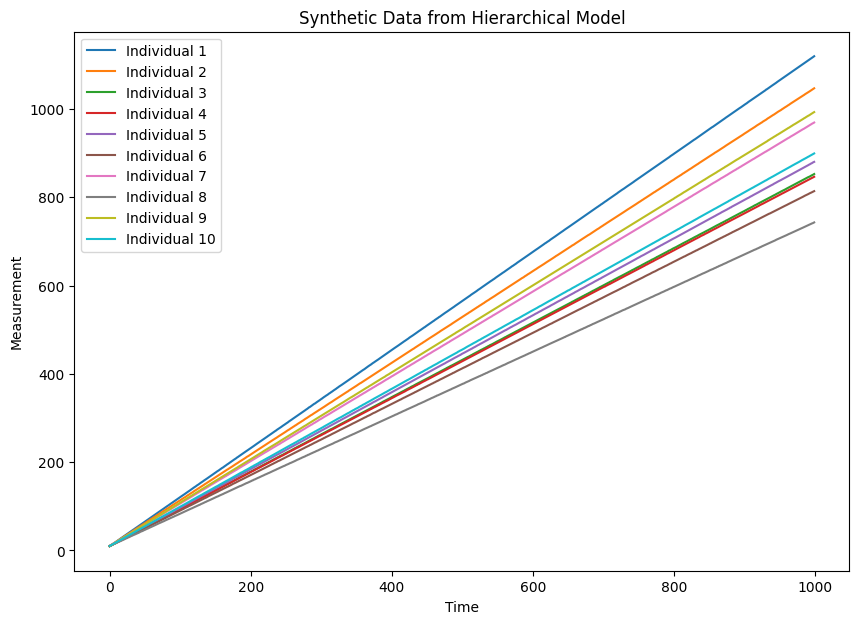

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Set the parameters
p0 = 10
sigma_t0 = sigma_v0 = 0.1
mean_t0 = mean_v0 = m = 1, 
sigma_xi = sigma_tau = sigma = 0.1
N = 10
K = 1000

# Function to calculate the trajectory
def calculate_trajectory(t, p0, v0, t0, alpha, tau):
    return p0 + v0 * (alpha * (t - t0 - tau) + t0)

# Generate synthetic data
t0 = np.random.normal(loc=mean_t0, scale=sigma_t0)
v0 = np.random.normal(loc=mean_v0, scale=sigma_v0)

alpha = np.exp(np.random.normal(scale=sigma_xi, size=N))
tau = np.random.normal(scale=sigma_tau, size=N)

y = np.zeros((N, K))
for i in range(N):
    for j in range(K):
        t = alpha[i] * (j - t0 - tau[i]) + t0
        y[i, j] = calculate_trajectory(t, p0, v0, t0, alpha[i], tau[i]) + np.random.normal(scale=sigma)

# Plot the generated data for each individual
plt.figure(figsize=(10,7))
for i in range(N):
    plt.plot(range(K), y[i, :], label=f'Individual {i+1}')

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Synthetic Data from Hierarchical Model')
plt.legend()
plt.show()


**3. Propose a Metropolis-Hastings sampler to sample from the a posteriori distribution $p(z | y, \theta)$ of
the latent variable $z = (z_{\text{pop}}, z_i)_{i\in J1,N K} = (t0, v0, \xi_i, \tau_i)_{i\in J1,N K} \in \mathbb{R}^{2N +2}$.
A natural choice for the proposal distribution is to consider a multivariate Gaussian distribution
$\mathcal{N} (z, \sigma_{\text{prop}}^2I)$. Thus, the acceptance ratio simply writes $1 \land \frac{\pi(z^*)}{\pi(z^{(k)})}$. This algorithm is called
Symmetric Random Walk Hasting-Metropolis algorithm.**


In [3]:
# Log posterior function
def compute_log_posterior(y, z, p0, t0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi_step, sigma_tau_step):
    
    t0, v0 = z[0:2]
    xi = z[2:N+2].reshape(-1, 1)
    tau = z[N+2:].reshape(-1, 1)  
    
    ti = np.exp(xi) * (t - t0 - tau)  
    dz = np.sum((y - d(ti + t0, p0, v0, t0)) **2)
    
    pz = (np.sum(xi ** 2) / (2 * sigma_xi_step **  2) + np.sum(tau ** 2) / (2 * sigma_tau_step ** 2) + (t0 - mean_t0) ** 2 / (2 * sigma_t0 ** 2) + (v0 - mean_v0) ** 2 / (2 * sigma_v0 ** 2))
    
    return dz, pz

# Trajectory function
def d(t, p0, v0, t0):
    return p0 + v0 * (t - t0)

# Symmetric Random Walk Hasting-Metropolis function
def SRWHM(y, z, p0, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi, sigma_tau, sigma_xi_step, sigma_tau_step, N, maxiter=10000):

    mean_prop = [mean_t0, mean_v0] + (2 * N) * [0]
    cov_prop = [sigma_t0, sigma_v0] + [sigma_xi_step] * N +  [sigma_tau_step] * N
    cov_prop = cov_prop = 0.005 * np.eye(2 * N + 2) * cov_prop
    
    z_list = [z]
    t = np.arange(K).reshape(1, -1)
    
    for k in range(maxiter):
        zk = np.random.multivariate_normal(mean=z, cov=cov_prop)
        dz, pk = compute_log_posterior(y, zk, p0, t0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi_step, sigma_tau_step)
        d_cur, p_cur = compute_log_posterior(y, z, p0, t0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi_step, sigma_tau_step)
        log_alpha = min(0, dz + pk - d_cur - p_cur)
        log_uk = np.log(np.random.rand())
        
        if log_uk < log_alpha:
            z = zk.copy()
        z_list.append(z)

    return z_list



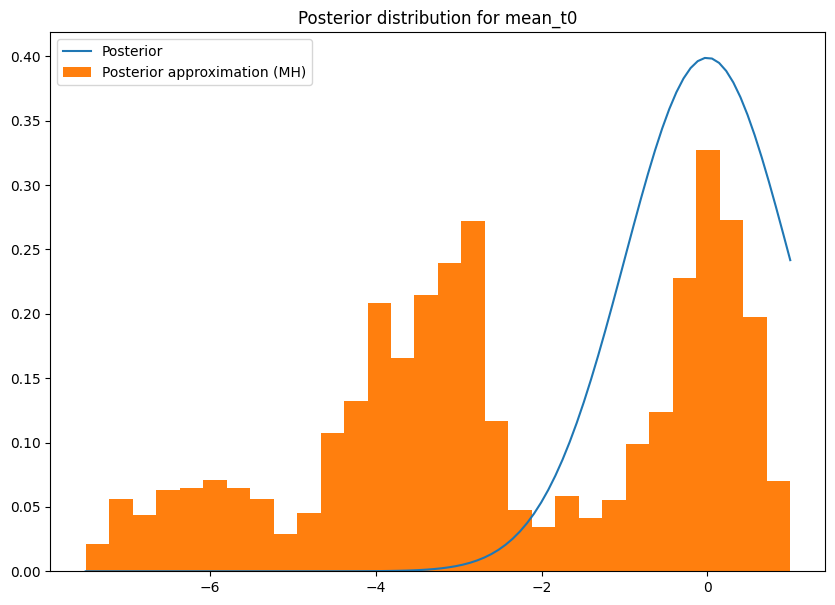

In [48]:
# Set the parameters
randomstate = 42
p0 = 10
sigma_t0 = sigma_v0 = 1
mean_t0 = 0
mean_v0 = 1
m = m_xi = m_tau = 6
v = v_xi = v_tau = 3
sigma_xi = sigma_tau = sigma_xi_step = sigma_tau_step = 0.1
N = 10
K = 1000
sigma_xi = np.sqrt(invwishart.rvs(df = m_xi, scale = v_xi, size = 1, random_state = randomstate))
sigma_tau = np.sqrt(invwishart.rvs(df = m_tau, scale = v_tau, size = 1, random_state = randomstate))
sigma = np.sqrt(invwishart.rvs(df = m, scale = v, size = 1, random_state= randomstate))

# Initial state
z = np.random.normal(size=2*N+2)

# Observations
y = np.random.normal(size=(N, K))

samples = SRWHM(y, z, p0, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi, sigma_tau, sigma_xi_step, sigma_tau_step, N, maxiter=10000)

# Extract the samples for t0
t0_samples = [sample[0] for sample in samples]

# Plot the posterior distribution for t0
x_values = np.linspace(min(t0_samples), max(t0_samples), 100)
y_values = stats.norm.pdf(x_values, loc=mean_t0, scale=sigma_t0)

plt.figure(figsize=(10,7))
plt.plot(x_values, y_values, label='Posterior')
plt.hist(t0_samples, bins=30, density=True, stacked=True, label='Posterior approximation (MH)')
plt.title('Posterior distribution for mean_t0')
plt.legend()
plt.show()

$\textbf{4. Compute the optimal parameters}$
$$ \theta^{(k)} = \underset{\theta \in \Theta}{argmax} \{ - \Phi (\theta) + < S_k | \Psi(\theta) >  \}$$

We consider the log-likelihood function of the form:

\begin{equation}
q(y,z;\theta) = \exp \left[−\phi(\theta) + <S(y,z), \psi(\theta)>\right]
\end{equation}

where the vector function $\psi(\theta)$ and scalar function $\phi(\theta)$ are given by:

\begin{equation}
\psi(\theta) = 
  \begin{bmatrix}
  \displaystyle\frac{-KN}{2\sigma^2} \\\\
  \displaystyle\frac{-N}{2\sigma^2_{\xi}} \\\\ 
  \displaystyle\frac{-N}{2\sigma^2_{\tau}} \\\\ 
  \displaystyle\frac{\overline{v_0}}{\sigma^2_{v_0}} \\\\
  \displaystyle\frac{\overline{t_0}}{\sigma^2_{t_0}} \\\\
  \end{bmatrix}  
\end{equation}

\begin{equation}
\Phi(\theta) = 
  \begin{bmatrix}
  (NK+m+2)\log \sigma \\\\
  (N+m_\xi+2)\log \sigma_\xi \\\\
  (N+m_\tau+2)\log \sigma_\tau \\\\ 
  \overline{v_0}^2(\displaystyle\frac{1}{2\sigma_{v_0}^2} + \frac{1}{2s_{v_0}^2}) - \frac{\overline{v_0}\cdot\overline{\overline{v_0}}}{s_{v_0}^2} \\\\
  \overline{t_0}^2(\displaystyle\frac{1}{2\sigma_{t_0}^2} + \frac{1}{2s_{t_0}^2}) - \frac{\overline{t_0}\cdot\overline{\overline{t_0}}}{s_{t_0}^2} \\\\
  \end{bmatrix}
\end{equation}

The optimal parameters at step $k$ are obtained by maximizing the log-likelihood function, i.e.,

\begin{equation}
\theta^k = \text{argmax}_\theta \{-\phi(\theta) + <S^k, \psi(\theta)>\}
\end{equation}

Let's denote $f_k(\theta)=-\phi(\theta) + <S^k, \psi(\theta)>$ at iteration $k$. The maximum a posteriori (MAP) estimator corresponds to $\theta^k$ for which $\nabla_\theta f_k(\theta^k)= 0$. We have

\begin{equation}
\nabla_\theta f_k(\theta) = - \nabla_\theta \phi(\theta) + <S^k, \nabla_\theta \psi(\theta)>
\end{equation}

Setting the gradient to zero gives the update rules for the parameters at each step:

\begin{equation}
\nabla_\theta f_k(\theta^k)= 0 \implies \theta^k= \begin{bmatrix}
  \big(\displaystyle\frac{S_5^k}{\sigma^2_{t_0}} +  \frac{\overline{\overline{t_0}}}{s_{t_0}^2}\big)\big(\displaystyle\frac{1}{\sigma_{t_0}^2} + \frac{1}{s_{t_0}^2}\big)^{-1}\\
  \big(\displaystyle\frac{S_4^k}{\sigma^2_{v_0}} + \frac{\overline{\overline{v_0}}}{s_{v_0}^2} \big) \big(\displaystyle\frac{1}{\sigma_{v_0}^2} + \frac{1}{s_{v_0}^2}\big)^{-1} \\
  \displaystyle\sqrt{\frac{N S_2^k}{N+m_\xi+2}} \\
  \displaystyle\sqrt{\frac{N S_3^k}{N+m_\tau+2}} \\
  \displaystyle\sqrt{\frac{KN S_1^k}{NK+m+2}} \\
  \end{bmatrix}
\end{equation}


In [60]:
import numpy as np

# Define the step size function
def step_size(k, Nb, alpha):
    if k <= Nb:
        return 1
    else:
        return (k - Nb) ** -alpha

def compute_sufficient_statistics(y, z, N, K=20):
    eps = np.exp(z[2:N+2])**2
    S1 = np.sum(eps) / (N * K)
    S2 = np.sum(np.array(z[2:N+2])) / N
    S3 = np.sum(np.array(z[N+3:])) / N
    S4 = z[1]
    S5 = z[0]

    return np.array([S1, S2, S3, S4, S5])


def compute_theta(S, N, K, m_xi, m_tau, m, sigma_t0, sigma_v0, s_t0, s_v0, mean_t0, mean_v0):
    S1, S2, S3, S4, S5 = S
    
    t0 = (S5 / sigma_t0**2 + mean_t0 / s_t0**2) / (1 / sigma_t0**2 + 1 / s_t0**2)
    v0 = (S4 / sigma_v0**2 + mean_v0 / s_v0**2) / (1 / sigma_v0**2 + 1 / s_v0**2)
    sigma_xi = np.sqrt(N * S2 / (N + m_xi + 2))
    sigma_tau = np.sqrt(N * S3 / (N + m_tau + 2))
    sigma = np.sqrt(K * N * S1 / (K * N + m + 2))
    
    return np.array([t0, v0, sigma_xi, sigma_tau, sigma])


def HM_SAEM(y, z_init, theta_init, N, alpha, maxIter):
    # Initialize
    z = z_init
    theta = theta_init
    S = compute_sufficient_statistics(y, z, N, K)
    m_xi = m_tau = m = 0.1
    s_t0 = s_v0 = 0.1
    
    for k in range(maxIter):
        epsilon = step_size(k, N, alpha)
        z_new = SRWHM(y, z, p0, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_xi, sigma_tau, sigma_xi_step, sigma_tau_step, N, maxiter=1000)
        z_new = z_new[-1]
        S_new = compute_sufficient_statistics(y, z_new, N, K)
        S = np.array(S) + epsilon * (np.array(S_new) - np.array(S))
        theta = compute_theta(S, N, K, m_xi, m_tau, m, sigma_t0, sigma_v0, s_t0, s_v0, mean_t0, mean_v0)
        z = z_new
    
    return theta
   

In [73]:
# Set the parameters
p0 = 10
sigma_t0 = sigma_v0 = 0.1
mean_t0 = mean_v0 = 1
sigma_xi = sigma_tau = sigma = 0.1
N = 10
K = 1000
z_init = np.random.normal(size=2*N+2)
theta_init = np.random.normal(size=5)
Nb = 100
alpha = 0.5
maxIter = 100
theta = HM_SAEM(y, z_init, theta_init, N, alpha, maxIter)


In [74]:
print('True parameters:')
print(f'mean_t0 = {mean_t0}')
print(f'mean_v0 = {mean_v0}')
print(f'sigma_t0 = {sigma_t0}')
print(f'sigma_v0 = {sigma_v0}')
print(f'sigma_xi = {sigma_xi}')
print(f'sigma_tau = {sigma_tau}')
print(f'sigma = {sigma}')
print('Estimated parameters:')
print(f'mean_t0_est = {theta[0]}')
print(f'mean_v0_est = {theta[1]}')
print(f'sigma_t0_est = {theta[2]}')
print(f'sigma_v0_est = {theta[3]}')
print(f'sigma_xi_est = {theta[4]}')

True parameters:
mean_t0 = 1
mean_v0 = 1
sigma_t0 = 0.1
sigma_v0 = 0.1
sigma_xi = 0.1
sigma_tau = 0.1
sigma = 0.1
Estimated parameters:
mean_t0_est = -3.8748509565030775
mean_v0_est = 14.926126508572866
sigma_t0_est = 5.29135332528847
sigma_v0_est = 0.7570175598020729
sigma_xi_est = 1.6414725943434484e+148


$\textbf{5. Propose a Metropolis-Hastings within Gibbs sampler to sample from the a posteriori distribution of}$ $z_i = (\xi_i,\tau_i)$.

In [81]:
def HMwG_zi(y, t0, v0, tau , xi, p0, theta, sigma_sim):
    
    tau_sim = np.zeros(N)
    xi_sim = np.zeros(N)

    # Parameters    
    sigma_tau = theta[0]
    sigma_xi = theta[1]
    
    sim_sigma_tau = sigma_sim[0]
    sim_sigma_xi = sigma_sim[1]
    
    tk = np.arange(K)

    for i in range(N):
        
        yi = y[i, :]
        
        # current state
        ti = np.exp(xi[i]) * (tk - t0 - tau[i])
        di = np.sum((yi - d(ti + t0, p0, v0, t0)) ** 2)
        p1 = -(tau[i] / sigma_tau) ** 2 / 2

        # proposal
        tau_proposed = np.random.normal(tau[i], sim_sigma_tau)
        ti = np.exp(xi[i]) * (tk - t0 - tau_proposed)
        di_proposed = np.sum((yi - d(ti + t0, p0, v0, t0)) ** 2)
        p2 = -(tau_proposed / sigma_tau) ** 2 / 2

        # acceptance-rejection
        log_alpha_tau = min( 0 , di_proposed - p1 - di + p2 ) 
        log_u = np.log(np.random.uniform())
        
        if log_u - log_alpha_tau < 0 : 
            tau_sim[i] = tau_proposed
        else:
            tau_sim[i] = tau[i]
        
        # current state
        ti = np.exp(xi[i]) * (tk - t0 - tau_sim[i])
        di = np.sum((yi - d(ti + t0, p0, v0, t0)) ** 2)
        p1 = - (xi[i]/ sigma_xi) ** 2 / 2

        # proposal
        xi_proposed = np.random.normal(xi[i], sim_sigma_xi)
        ti = np.exp(xi_proposed) * (tk - t0 - tau_sim[i])
        di_proposed = np.sum((yi - d(ti + t0, p0, v0, t0)) ** 2)
        p2 = - (xi_proposed / sigma_xi) ** 2 / 2

        # acceptance-rejection
        log_alpha_xi = min (0, di_proposed - p1 - di + p2)
        log_u = np.log(np.random.uniform())
        
        if log_u - log_alpha_tau < 0 : 
            xi_sim[i] = xi_proposed
        else:
            xi_sim[i] = xi[i]

            
    return tau_sim, xi_sim

In [84]:
zi = np.random.random((N,2))
tau , xi = zi[:,0] , zi[:,1]
theta_init = np.random.normal(size=5)
sigma_sim_zi = [0.01,0.01]
theta = [theta_init[3],theta_init[2]]
sigma_sim_zi = [0.01,0.01]
for i in range(10000):
    tau , xi = HMwG_zi(y, t0, v0, tau , xi , p0, theta, sigma_sim_zi)
    
print('tau =' , tau )
print('xi =' , xi )

tau = [-38.57317351 -38.86558704 -38.82290169 -38.73753207 -38.36956231
 -39.23321301 -39.80246707 -39.80083243 -39.49633492 -39.00866238]
xi = [2.79920242 1.15562398 0.19003619 0.31647848 0.1150669  0.35990766
 0.78029919 0.28012031 0.5354368  0.8277618 ]


$\textbf{6. Likewise, propose a HMwG sampler for the a posteriori distribution of}$ $z_{pop} = (t_0, v_0)$



In [85]:
def HMwG_zpop(y, t0, v0, tau,xi, p0, sigma_t0, sigma_v0, sigma, theta, sigma_sim):
    
    t0_final = 0
    v0_final = 0
    
    dist = np.zeros((N,K))
    dist_ = np.zeros((N,K))
    
    # Parameters    
    t0_tr = theta[0]
    v0_tr = theta[1]
    
    sim_sigma_t0 = sigma_sim[0]
    sim_sigma_v0 = sigma_sim[1]
    
    # Simulated 
    tk = np.arange(K)
    t0_sim = np.random.normal(loc=t0, scale=sim_sigma_t0, size=1)
    v0_sim = np.random.normal(loc=v0, scale=sim_sigma_v0, size=1)
    
     
    for j in range (K) : 
        t = np.exp(xi)*(tk[j] - t0 - tau) + t0
        dist[:,j] = d(t , p0, v0, t0)

        t_ = np.exp(xi)*(tk[j] - t0_sim - tau ) + t0_sim
        dist_[:,j]= d(t_ , p0, v0, t0_sim)
    
    p1 = - np.sum((y - dist)**2) / (2 * sigma**2 )
    p2 = - np.sum((y - dist_)**2) / (2 * sigma**2 )
    p3 = - np.sum((t0 - t0_tr)**2) / (2 * sigma_t0**2 )
    p4 = - np.sum((t0_sim - t0_tr)**2) / (2 * sigma_t0**2 )
    
    log_alpha = min (0 , - p1 + p2 - p3 + p4)   
    log_u = np.log(np.random.uniform())
        
    if log_u - log_alpha < 0 : 
        t0_final = t0_sim
    else:
        t0_final = t0
       
    
    for j in range (K) : 
        t = np.exp(xi)*(tk[j] - t0_sim - tau) + t0_sim
        dist[:,j] = d(t , p0, v0, t0_sim)
    
        t_ = np.exp(xi)*(tk[j] - t0_sim - tau ) + t0_sim
        dist_[:,j] = d(t_ , p0, v0_sim, t0_sim)

    p1 = - np.sum((y - dist)**2) / (2 * sigma**2 )
    p2 = - np.sum((y - dist_)**2) / (2 * sigma**2 )
    p3 = - np.sum((v0 - v0_tr)**2) / (2 * sigma_v0**2 )
    p4 = - np.sum((v0_sim - v0_tr)**2) / (2 * sigma_v0**2 )
    
    log_alpha = min (0 , - p1 + p2 - p3 + p4)
    log_u = np.log(np.random.uniform())
        
    if log_u - log_alpha < 0 : 
        v0_final = t0_sim
    else:
        v0_final = v0   
    
    return t0_final , v0_final 

In [88]:
t0_sim , v0_sim = 0, 0 
theta = [theta_init[0],theta_init[1]] 
sigma_sim_pop = [0.01,0.01]

tau = zi[:,0]
xi = zi[:,1]

for i in range(10000):
    t0_sim , v0_sim =  HMwG_zpop(y, t0_sim , v0_sim, tau , xi , p0, sigma_t0, sigma_v0, sigma, theta, sigma_sim_pop)
    
print('The true t0 = ' , t0)
print('The estiamted t0 = ' , t0_sim)
print('The true v0 = ' , v0)
print('The estiamted v0 = ' , v0_sim)

The true t0 =  1.0103660613950736
The estiamted t0 =  [39.66026812]
The true v0 =  0.981866039380177
The estiamted v0 =  [39.64582938]


$\textbf{8. Explain what is the advantages of a Block Gibbs sampler over a "one-at-a-time" Gibbs sampler
for our model.}$

- Efficiency: Block Gibbs sampler updates multiple variables simultaneously, which can be more efficient when variables are highly correlated.
- Reduced autocorrelation: The samples generated by a Block Gibbs sampler often have lower autocorrelation, leading to a more representative sample of the target distribution. Better exploration of the state space: By updating blocks of variables simultaneously, the Block Gibbs sampler can explore the state space more effectively.
- Parallelization: If the blocks of variables are independent, the updates within each block can be performed in parallel, leading to further computational efficiency.

In the context of your model, if the latent variables are highly correlated or numerous, using a Block Gibbs sampler could lead to more efficient and accurate estimation of the model parameters.


### $\textbf{Exercice 2: Multiplicative Hasting-Metropolis}$

In [9]:
import numpy as np
from scipy.stats import uniform, norm, expon

# Define the proposal distribution
def proposal(x):
    epsilon = uniform.rvs(loc=-1, scale=2)  # epsilon ~ Uniform(-1, 1)
    b = np.random.binomial(1, 0.5)  # b ~ Bernoulli(0.5)
    if b == 1:
        return epsilon * x
    else:
        return x / epsilon

# Define the acceptance probability
def alpha(x, y, pi):
    return min(1, (abs(y) * pi(y)) / (abs(x) * pi(x)))

# Define the multiplicative Hasting-Metropolis sampler
def multiplicative_HM_sampler(pi, x0, n_samples):
    samples = [x0]
    for _ in range(n_samples):
        x = samples[-1]
        y = proposal(x)
        u = np.random.uniform()
        if u < alpha(x, y, pi):
            samples.append(y)
        else:
            samples.append(x)
    return samples

# Target distribution 1: Normal distribution
pi1 = norm.pdf
samples1 = multiplicative_HM_sampler(pi1, x0=0.5, n_samples=10000)

# Target distribution 2: Uniform distribution
pi2 = uniform.pdf
samples2 = multiplicative_HM_sampler(pi2, x0=0.5, n_samples=10000)

# Target distribution 3: exponential distribution
pi3 = expon.pdf
samples3 = multiplicative_HM_sampler(pi3, x0=0.5, n_samples=10000)


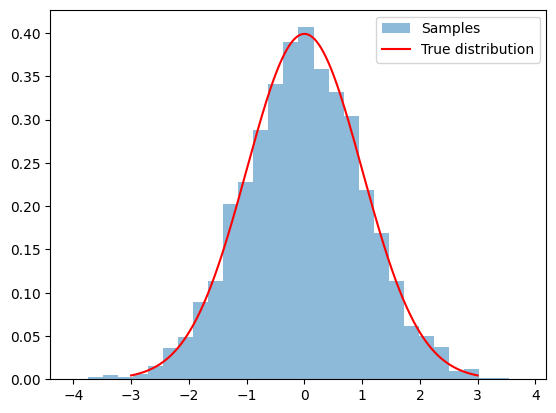

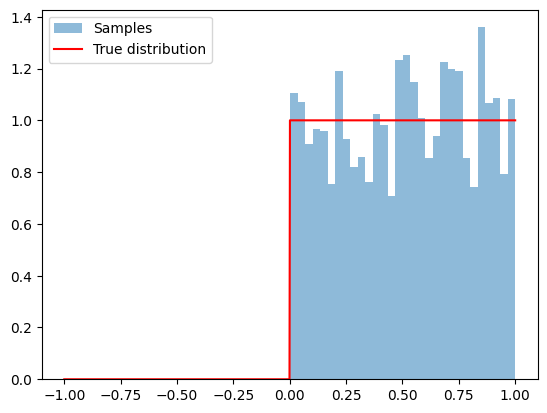

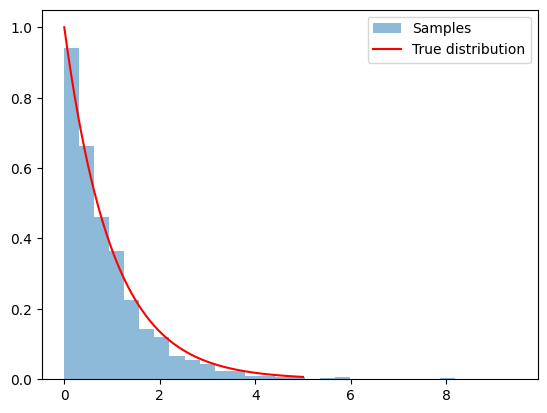

In [10]:
import matplotlib.pyplot as plt

# Plot histogram of samples for target distribution 1
plt.hist(samples1, bins=30, density=True, alpha=0.5, label='Samples')
x = np.linspace(-3, 3, 1000)
plt.plot(x, pi1(x), 'r', label='True distribution')
plt.legend()
plt.show()

# Plot histogram of samples for target distribution 2
plt.hist(samples2, bins=30, density=True, alpha=0.5, label='Samples')
x = np.linspace(-1, 1, 1000)
plt.plot(x, pi2(x), 'r', label='True distribution')
plt.legend()
plt.show()

# Plot histogram of samples for target distribution 3
plt.hist(samples3, bins=30, density=True, alpha=0.5, label='Samples')
x = np.linspace(0, 5, 1000)
plt.plot(x, pi3(x), 'r', label='True distribution')
plt.legend()
plt.show()
